In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import tqdm as tqdm
import os

In [2]:
img = cv2.imread('Assignment_04_Grid_Map.png', cv2.IMREAD_GRAYSCALE)
colour_img = cv2.imread('Assignment_04_Grid_Map.png', cv2.IMREAD_COLOR)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Task 1 - Generating Laser Range Measurements using Ray Casting Tecnique

In [3]:
def sensor_model(pose, map):
    n_rays = 125
    angle_gap = 2

    max_range = 12
    measurements = {}

    directions = np.arange(-n_rays, n_rays + angle_gap, angle_gap)
    
    for direction in directions:
        ray_angle = pose[2] + direction * np.pi / 180
        x, y = pose[0], pose[1]
        
        step1 = 0.04/(np.cos(ray_angle))
        step2 = 0.04/(np.sin(ray_angle))
        step = min(np.fabs(step1), np.fabs(step2))
        
        for distance in np.arange(0, max_range, step):
            x_endpoint_pixel = round((x + distance * np.cos(ray_angle))/0.04)
            y_endpoint_pixel = round((y + distance * np.sin(ray_angle))/0.04)
            
            if map[x_endpoint_pixel, y_endpoint_pixel] == 0:
                measurements[direction] = (distance, x_endpoint_pixel, y_endpoint_pixel)
                break
                
        # Should we add ray with max range distance?
        # measurements[direction] = (distance, x_endpoint_pixel, y_endpoint_pixel)
    return measurements

In [4]:
robot_pose = [4, 5.4, 1.57]
measurements = sensor_model(robot_pose, img)

In [5]:
# Visualize robot pose and measurement generated at that pose

cv2.circle(colour_img, (int(robot_pose[1]/0.04), int(robot_pose[0]/0.04)), 5, (0, 0, 255), -1)
for key in measurements:
    cv2.line(colour_img, (int(robot_pose[1]/0.04), int(robot_pose[0]/0.04)), (measurements[key][2], measurements[key][1]), (0, 255, 0), 1)

cv2.imshow('image', colour_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Task 2 - Measurement Likelihood $P(z | x,m)$ based on End-Point Model

In [6]:
## NOT OPTIMIZED
# def compute_nearest_occupied_cell(pos_pixel, map):
#     x = pos_pixel[0]
#     y = pos_pixel[1]

#     min_dist = np.inf
#     nearest_cell = None
#     # Find the nearest occupied cell
#     # Check if the current cell is occupied
#     # Brute Force search
#     for i in range(map.shape[0]):
#         for j in range(map.shape[1]):
#             if map[i, j] == 0:
#                 dist = np.sqrt((x-i)**2 + (y-j)**2)
#                 if dist < min_dist:
#                     min_dist = dist
#                     nearest_cell = (i, j)
#     return nearest_cell



In [7]:
# Optimized computation of Nearest Occupied Cell for given cell
def compute_nearest_occupied_cell(pos_pixel, _map):
    x, y = pos_pixel
    occupied_indices = np.argwhere(_map == 0)
    
    if len(occupied_indices) == 0:
        return None  # No occupied cells found
    
    dist = np.sqrt(np.sum((occupied_indices - np.array([x, y]))**2, axis=1))
    min_index = np.argmin(dist)
    
    nearest_cell = tuple(occupied_indices[min_index])
    
    return nearest_cell

In [8]:
# Compute the Likelihood Field Map
def likelihood_field(map):

    # If the map is already saved, load it
    if os.path.exists('likelihood_field.png'):
        return cv2.imread('likelihood_field.png', cv2.IMREAD_GRAYSCALE)
    
    # Initialize the likelihood field
    l = np.zeros(map.shape)
    # For each cell in the map - using tqdm to visualize the progress
    for i in tqdm.tqdm(range(len(l[:, 0]))):
        for j in range(len(l[0, :])):
            # If the cell is occupied
            closest_point = compute_nearest_occupied_cell((i, j), map)
            # Compute the distance to the nearest occupied cell
            dist = np.sqrt((i-closest_point[0])**2 + (j-closest_point[1])**2)
            # Compute the probability of the cell being occupied
            # Sigma = 0.35 
            l[i, j] = np.exp(-(dist*0.04)**2/(2*0.35**2))
    # Normalize the likelihood field to a range between 0 and 255
    l = l/np.max(l)*255
    return l

In [9]:
l = likelihood_field(img)
cv2.imshow('image', l)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# Save the Likelihood Field Map
cv2.imwrite('likelihood_field.png', l)
cv2.imwrite('likelihood_field.pbm', l)

True

In [11]:
reference_robot_pose = [4, 5.4, 1.57]
reference_measurement = sensor_model(reference_robot_pose, img)

In [12]:
# Given the measurement z* (measurement from some reference robot pose), transform that measurement z*
# so that endpoints of that measurement end in pixels/cells like if that measurement was taken from some assumed robot pose

# Basically all we need are relative angles of rays and distances for that angles, and we just project the same way as in Task1 (for assumed robot pose)
def transform_endpoints(measurements, assumed_pose):
    transformed_measurements = {}
    for relative_angle in measurements:
        distance = measurements[relative_angle][0]
        # Given relative angle and measured distance for that angle, compute endpoint for that ray given the new assumed robot pose)
        new_x_endpoint_pixel = round(assumed_pose[0] + distance*np.cos(assumed_pose[2] + relative_angle*np.pi/180))
        new_y_endpoint_pixel = round(assumed_pose[1] + distance*np.sin(assumed_pose[2] + relative_angle*np.pi/180))
        
        # Take into account that rays can go out of the map now (if ray go out of the map, mark its pixel location as None,None)
        boundary_x = 400
        boundary_y = 640
        if 0 <= new_x_endpoint_pixel < boundary_x and 0 <= new_y_endpoint_pixel < boundary_y:
            transformed_measurements[relative_angle] = (distance, new_x_endpoint_pixel, new_y_endpoint_pixel)
        else:
            transformed_measurements[relative_angle] = (distance, None, None)
    return transformed_measurements

In [13]:
# Generate few random poses 
poses = []
for i in range(100):
    poses.append([np.random.randint(0, 400), np.random.randint(0, 680), np.random.randint(-180, 180) * np.pi/180])

In [14]:
# Compute Measurement Likelyhood for each pose
measurements_likelihood = [([int(reference_robot_pose[0]/0.04), int(reference_robot_pose[1]/0.04), reference_robot_pose[2]], 1.00)]
for pose in poses:
    transformed_measurements = transform_endpoints(reference_measurement, pose)
    # Calculate the likelihood of the measurements from the likelihood field
    probability = 1
    # For each ray in measurement
    for relative_angle in transformed_measurements:
        if transformed_measurements[relative_angle][1] is not None:
            probability *= l[transformed_measurements[relative_angle][1], transformed_measurements[relative_angle][2]]/255
        else:
            probability *= 0.01
            
    measurements_likelihood.append((pose, probability))

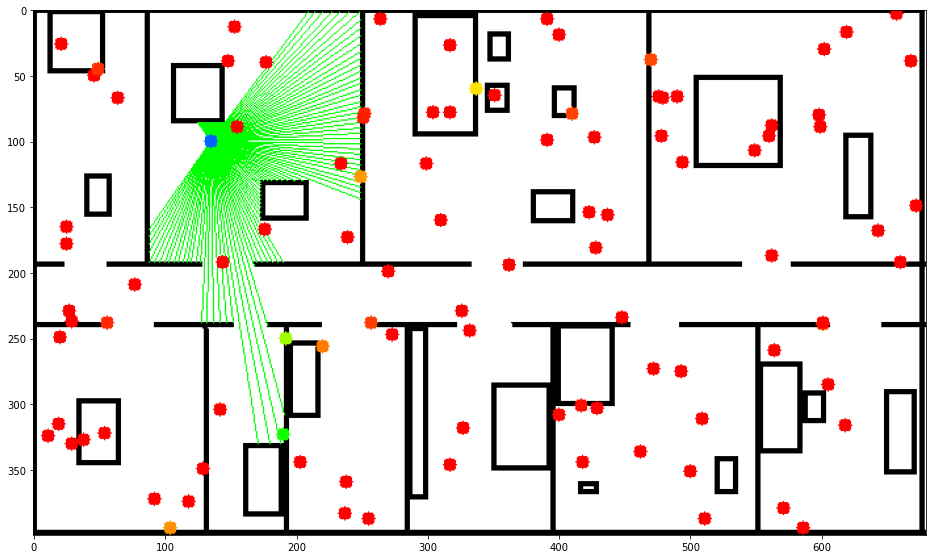

In [15]:
# Plot measurement likelihood for each pose in colour_img

# Convert the color_img to RGB format
cv2_image = cv2.cvtColor(colour_img, cv2.COLOR_BGR2RGB)

# Iterate through measurements_likelihood to add poses and probabilities to the image
for pose, probability in measurements_likelihood:
    # Convert pose to integers and modify the image to add the pose and the probability 
    # cv2_image[int(pose[0]), int(pose[1])] = (int(255 * probability), 0, 0)
    # Add a circle to the image to visualize the robot pose
    color = hsv_to_rgb([probability * 0.6, 1, 1])
    color = tuple(int(i * 255) for i in color)
    cv2.circle(cv2_image, (int(pose[1]), int(pose[0])), 5, color, -1)

# Display the modified image
plt.figure(figsize=(16,16))
plt.imshow(cv2_image)